# Business Analytics und Künstliche Intelligenz

Prof. Dr. Jürgen Bock & Maximilian-Peter Radtke

---

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Modellbewertung auf Basis eines Validierungssets

Für die Modellbewertung auf Basis eines Validierungssets, benutzen wir die Funktion `train_test_split` von Scikit-Learn.

In [3]:
from sklearn.model_selection import train_test_split

Um zu zeigen wie dies funktioniert und welche Nachteile dieser Ansatz haben kann, führen wir eine Klassifikation auf dem Auto-Datensatz aus bezüglich der `Origin` Spalte aus.

In [4]:
auto = pd.read_csv('data/Auto_clean.csv')
auto['intercept'] = 1

In [5]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,intercept
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,1
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,1
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,1
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,1
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,1


Mithilfe von `train_test_split` können wir die Daten in ein Trainingsset und ein Validierungsset / Testset unterteilen

In [6]:
X = auto.drop(['year', 'origin', 'name'], axis=1)
y = auto.origin
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2)

Wir nutzen den LDA Klassifikator, um die Herkunft der Autos auf Basis der Daten vorherzusagen.

In [8]:
ldaAuto = LinearDiscriminantAnalysis()
ldaAuto.fit(XTrain, yTrain)
print('Trainingsfehler ', 1-ldaAuto.score(XTrain, yTrain))
print('Testfehler: ', 1-ldaAuto.score(XTest, yTest))

Trainingsfehler  0.23642172523961658
Testfehler:  0.2784810126582279


Der Testfehler ist nur minimal größer als der Trainingsfehler. Allerdings kann diese Ansicht irreführend sein, da die Aufteilung zwischen Trainingsset und Validierungsset zufällig ist. Mit dem  `random_state`-Parameter lässt sich festlegen welche Mischung der Daten jeweils vorgenommen wird. Wenn uns über verschiedene Random States die Fehler ausgeben lassen, bekommen wir verschiedenen Fehler.

In [11]:
for i in range(10):
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=i)
    ldaAuto = LinearDiscriminantAnalysis()
    ldaAuto.fit(XTrain, yTrain)
    print('Random State:', i)
    print('Trainingsfehler:', 1-ldaAuto.score(XTrain, yTrain))
    print('Testfehler:', 1-ldaAuto.score(XTest, yTest))
    print('\n')

Random State: 0
Trainingsfehler: 0.2460063897763578
Testfehler: 0.25316455696202533


Random State: 1
Trainingsfehler: 0.25559105431309903
Testfehler: 0.189873417721519


Random State: 2
Trainingsfehler: 0.24281150159744413
Testfehler: 0.3291139240506329


Random State: 3
Trainingsfehler: 0.25559105431309903
Testfehler: 0.2784810126582279


Random State: 4
Trainingsfehler: 0.2587859424920128
Testfehler: 0.2911392405063291


Random State: 5
Trainingsfehler: 0.23961661341853036
Testfehler: 0.35443037974683544


Random State: 6
Trainingsfehler: 0.24920127795527158
Testfehler: 0.240506329113924


Random State: 7
Trainingsfehler: 0.23003194888178913
Testfehler: 0.379746835443038


Random State: 8
Trainingsfehler: 0.23003194888178913
Testfehler: 0.2784810126582279


Random State: 9
Trainingsfehler: 0.2619808306709265
Testfehler: 0.26582278481012656




## K-Fold Cross-Validation

Ein Weg diese Streuung zu umgehen, ist der in der Vorlesung besprochenen Cross-Validation Ansatz. Hierzu importieren wir `KFold` aus scikit-learn.

In [12]:
from sklearn.model_selection import KFold

In [13]:
n_splits = 5
kf = KFold(n_splits, random_state=1, shuffle=True)
CVFoldTestErrors = []
CVFoldTrainErrors = []
for trainIndex, testIndex in kf.split(X):
    XTrain, XTest = X.iloc[trainIndex], X.iloc[testIndex]
    yTrain, yTest = y.iloc[trainIndex], y.iloc[testIndex]
    ldaAuto = LinearDiscriminantAnalysis()
    ldaAuto.fit(XTrain, yTrain)
    CVFoldTrainErrors.append(1-ldaAuto.score(XTrain, yTrain))
    CVFoldTestErrors.append(1-ldaAuto.score(XTest, yTest))
print('CV Trainingsfehler:\n', CVFoldTrainErrors)
print('CV Durchschnittlicher Trainingsfehler:', np.mean(CVFoldTrainErrors))
print('CV Testfehler:\n', CVFoldTestErrors)
print('CV Durchschnittlicher Testfehler:', np.mean(CVFoldTestErrors))

CV Trainingsfehler:
 [0.25559105431309903, 0.22364217252396168, 0.25159235668789814, 0.23566878980891715, 0.23885350318471332]
CV Durchschnittlicher Trainingsfehler: 0.2410695753037179
CV Testfehler:
 [0.189873417721519, 0.30379746835443033, 0.28205128205128205, 0.3076923076923077, 0.2564102564102564]
CV Durchschnittlicher Testfehler: 0.26796494644595914


Trotzdem gibt es eine gewisse Streuung zwischen den Ergebnissen, da auch hier zufällig die Splits ausgewählt werden. Wenn wir uns wieder über verschiedene Random States die Ergebnisse ausgeben lassen, erhalten wir das folgende Ergebnis:

In [14]:
n_splits = 5
for i in range(10):
    kf = KFold(n_splits, random_state=i, shuffle=True)
    CVFoldTestErrors = []
    CVFoldTrainErrors = []
    for trainIndex, testIndex in kf.split(X):
        XTrain, XTest = X.iloc[trainIndex], X.iloc[testIndex]
        yTrain, yTest = y.iloc[trainIndex], y.iloc[testIndex]
        ldaAuto = LinearDiscriminantAnalysis()
        ldaAuto.fit(XTrain, yTrain)
        CVFoldTrainErrors.append(1-ldaAuto.score(XTrain, yTrain))
        CVFoldTestErrors.append(1-ldaAuto.score(XTest, yTest))
    print('Random State:', i)
    print('CV Durchschnittlicher Trainingsfehler:', np.mean(CVFoldTrainErrors))
    print('CV Durchschnittlicher Testfehler:', np.mean(CVFoldTestErrors))
    print('\n')

Random State: 0
CV Durchschnittlicher Trainingsfehler: 0.2449095460002849
CV Durchschnittlicher Testfehler: 0.2653359298928919


Random State: 1
CV Durchschnittlicher Trainingsfehler: 0.2410695753037179
CV Durchschnittlicher Testfehler: 0.26796494644595914


Random State: 2
CV Durchschnittlicher Trainingsfehler: 0.24553224395107956
CV Durchschnittlicher Testfehler: 0.28825056799740345


Random State: 3
CV Durchschnittlicher Trainingsfehler: 0.24745324677967478
CV Durchschnittlicher Testfehler: 0.28065563128854265


Random State: 4
CV Durchschnittlicher Trainingsfehler: 0.2525630329053133
CV Durchschnittlicher Testfehler: 0.2885426809477442


Random State: 5
CV Durchschnittlicher Trainingsfehler: 0.2448953012759203
CV Durchschnittlicher Testfehler: 0.27036676403765003


Random State: 6
CV Durchschnittlicher Trainingsfehler: 0.2436132760831078
CV Durchschnittlicher Testfehler: 0.2703018500486855


Random State: 7
CV Durchschnittlicher Trainingsfehler: 0.250633890234224
CV Durchschnittlic

Um überhaupt keine Streuung in den Ergebnissen zu haben, können wir Leave One Out Cross Validation nutzen. Dazu setzen wir die Anazhl der Splits auf die Anzahl der Zeilen in dem Datensatz.

In [17]:
n_splits = X.shape[0]
kf = KFold(n_splits, random_state=1, shuffle=True)
CVFoldTestErrors = []
CVFoldTrainErrors = []
for trainIndex, testIndex in kf.split(X):
    XTrain, XTest = X.iloc[trainIndex], X.iloc[testIndex]
    yTrain, yTest = y.iloc[trainIndex], y.iloc[testIndex]
    ldaAuto = LinearDiscriminantAnalysis()
    ldaAuto.fit(XTrain, yTrain)
    CVFoldTrainErrors.append(1-ldaAuto.score(XTrain, yTrain))
    CVFoldTestErrors.append(1-ldaAuto.score(XTest, yTest))
print('LOOCV Durchschnittlicher Trainingsfehler:', np.mean(CVFoldTrainErrors))
print('LOOCV Durchschnittlicher Testfehler:', np.mean(CVFoldTestErrors))

LOOCV Durchschnittlicher Trainingsfehler: 0.2472858708700872
LOOCV Durchschnittlicher Testfehler: 0.2653061224489796


In [16]:
n_splits

392

Mit der `KFold`-Methode haben wir die Möglichkeit jegliche Art von Modell zu nutzen und genau zu bestimmen was mit den einzelnen Splits passiert. Falls wir aber einen Algorithmus von scikit-learn direkt nutzen, lässt sich Cross-Validation auch einfacher umsetzen. Hierzu müssen wir nur `cross_validate` importieren und anwenden.

In [18]:
from sklearn.model_selection import cross_validate

In [19]:
ldaAuto = LinearDiscriminantAnalysis()

In [21]:
scores = cross_validate(ldaAuto, X, y, cv=5, return_train_score=True)
print('Trainingsfehler:', 1-scores['train_score'])
print('Testfehler:', 1-scores['test_score'])

Trainingsfehler: [0.23961661 0.24600639 0.24203822 0.26433121 0.22611465]
Testfehler: [0.25316456 0.20253165 0.25641026 0.23076923 0.67948718]


# Data leakage

Data leakage tritt auf, wenn Informationen aus dem Testdatensatz unbeabsichtigt den Trainingsprozess beeinflussen, was zu überoptimistischen Leistungsabschätzungen führen kann.
Dies kann durch unsachgemäße Verwendung von Informationen aus dem gesamten Datensatz während des Trainings oder der Validierung verursacht werden.

Im folgenden wollen wir das Beispiel aus der Vorlesung nachbauen, um dies zu veranschaulichen.

Zunächst simulieren wir uns hierzu einen Datensatz für ein binäres Klassifikationsprobelm.

In [22]:
# Setze Parameter
num_obs = 50 # Anzahl Observationen
num_predictors = 5000 # Anzahl Prädiktoren
num_selected = 100 # Anzahl an Prädiktoren die genutzt werden sollen
num_splits = 5 # Anzahl CV Splits
random_seed = 42

# Setze random seed um Wiederholbarkeit zu gewährleisten
np.random.seed(random_seed)

# Simuliere Daten für binäres Klassifikationsproblem
X = np.random.randn(num_obs, num_predictors)
y = np.random.randint(0, 2, num_obs)

Die Daten sind vollkommen zufällig. Entsprechend gibt es keinen Zusammenhang zwischen $X$ und $y$, d.h. viel besser als der Zufall (Genaugikeit von 50%) sollte unser Modell eigentlich nicht werden. Trotzdem wollen wir es versuchen. Dazu wählen wir die 50 Prädiktoren aus, die am stärksten mit der Zielvariable korrelieren und schätzen basierend auf diesen ein Modell.

Im ersten Versuch wählen wir die Prädiktoren vor dem Train/Test Split aus $\rightarrow$ Data Leakage!

In [24]:
# Wähle die 100 Prädiktoren mit der stärksten Korrelation mit der Zielvariable aus
# Dieser Schritt passiert vor dem Train/Test Split! -> Data leakage
selected_predictors = np.argsort(
    np.abs(np.corrcoef(X.T, y)[num_predictors][:num_predictors])
)[-num_selected:]
X_selected = X[:, selected_predictors]

# Initialisiere Klassifikationsmodell
model = LinearDiscriminantAnalysis()

# Evaluiere "leaky" Modell mit cross validation
scores_leaky = cross_validate(model, X_selected, y, cv=num_splits)['test_score']

array([0.9, 1. , 1. , 0.9, 1. ])

Im zweiten Versuch nehmen wir die Auswahl der besten Prädiktoren mit in unseren Cross Validation Loop $\rightarrow$ kein Data Leakage!

In [25]:
kf = KFold(num_splits, shuffle=True)
CVFoldTestErrors = []
# Loop für cross validation
for trainIndex, testIndex in kf.split(X):
    # Train/Test Split der Daten
    X_train, X_test = X[trainIndex, :], X[testIndex, :]
    y_train, y_test = y[trainIndex], y[testIndex]

    # Wähle die 100 Prädiktoren mit der stärksten Korrelation mit der Zielvariable
    # erst nach dem Train/Test split aus
    # -> Kein Data leakage
    selected_predictors = np.argsort(
        np.abs(np.corrcoef(X_train.T, y_train)[num_predictors][:num_predictors])
    )[-num_selected:]
    X_train_selected = X_train[:, selected_predictors]
    X_test_selected = X_test[:, selected_predictors]

    # Initialisiere Modell
    model = LinearDiscriminantAnalysis()
    
    # Trainiere Modell auf Basis der Trainingsdaten
    model.fit(X_train_selected, y_train)
    
    # Evaluaiere das Modell auf Basis der Testdaten für spezifischen Fold
    CVFoldTestErrors.append(model.score(X_test_selected, y_test))

In [26]:
# Ausgabe der Testgenauigkeiten
print(f'Testgenauigkeit mit data leakage: {np.mean(scores_leaky)}')
print(f'Testgenauigkeit ohne data leakage: {np.mean(CVFoldTestErrors)}')

Testgenauigkeit mit data leakage: 0.96
Testgenauigkeit ohne data leakage: 0.48


# Übungsaufgaben

## Aufgabe 1

Nutzen Sie auch die logistische Regression und KNN um das Klassifikationsproblem aus der Übung zu lösen. Vergleichen Sie ihre Ergebnisse. Welcher Algorithmus schneidet am besten ab?

In [27]:
import statsmodels.api as sm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate, KFold

In [28]:
auto = pd.read_csv('data/Auto_clean.csv')
auto['intercept'] = 1
X = auto.drop(['year', 'origin', 'name'], axis=1)
y = auto.origin

In [29]:
ldaAuto = LinearDiscriminantAnalysis()
LDAscores = cross_validate(ldaAuto, X, y, cv=5, return_train_score=True)
print('Trainingsfehler:', 1-LDAscores['train_score'].mean())
print('Testfehler:', 1-LDAscores['test_score'].mean())

Trainingsfehler: 0.24362141592560183
Testfehler: 0.3244725738396623


In [30]:
KNNAuto = KNeighborsClassifier(n_neighbors=5)
KNNscores = cross_validate(KNNAuto, X.values, y.values, cv=5, return_train_score=True)
print('Trainingsfehler:', 1-KNNscores['train_score'].mean())
print('Testfehler:', 1-KNNscores['test_score'].mean())

Trainingsfehler: 0.20217130298528718
Testfehler: 0.3011035378123985


In [31]:
from sklearn.metrics import accuracy_score

In [32]:
n_splits = 5
kf = KFold(n_splits, random_state=1, shuffle=True)
CVFoldTestErrors = []
CVFoldTrainErrors = []
for trainIndex, testIndex in kf.split(X):
    XTrain, XTest = X.iloc[trainIndex], X.iloc[testIndex]
    yTrain, yTest = y.iloc[trainIndex], y.iloc[testIndex]
    LogAuto = sm.MNLogit(yTrain, XTrain)
    LogAutoRes = LogAuto.fit()
    testError = 1 - accuracy_score(yTest, LogAutoRes.predict(XTest).idxmax(axis=1) + 1)
    trainError = 1 - accuracy_score(yTrain, LogAutoRes.predict(XTrain).idxmax(axis=1) + 1)
    CVFoldTrainErrors.append(trainError)
    CVFoldTestErrors.append(testError)
#print('CV Trainingsfehler:\n', CVFoldTrainErrors)
print('CV Durchschnittlicher Trainingsfehler:', np.mean(CVFoldTrainErrors))
#print('CV Testfehler:\n', CVFoldTestErrors)
print('CV Durchschnittlicher Testfehler:', np.mean(CVFoldTestErrors))

Optimization terminated successfully.
         Current function value: 0.500453
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.461297
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.471216
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.453800
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.451279
         Iterations 10
CV Durchschnittlicher Trainingsfehler: 0.221318247491911
CV Durchschnittlicher Testfehler: 0.24005193119117169


In [33]:
LogAutoRes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 origin   No. Observations:                  314
Model:                        MNLogit   Df Residuals:                      300
Method:                           MLE   Df Model:                           12
Date:                Thu, 25 Jan 2024   Pseudo R-squ.:                  0.5065
Time:                        18:40:28   Log-Likelihood:                -141.70
converged:                       True   LL-Null:                       -287.15
Covariance Type:            nonrobust   LLR p-value:                 3.811e-55
================================================================================
    origin=2       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
mpg             -0.0548      0.051     -1.081      0.280      -0.154       0.045
cylinders        1.7618      0.597      2.949      0.003       0.591       2.933
displacement    -0.1404      0.024     -5.958      0.000      -0.187      -0.094
horsepower      -0.0233      0.030     -0.779      0.436      -0.082       0.035
weight           0.0064      0.001      4.296      0.000       0.003       0.009
acceleration    -0.1848      0.139     -1.325      0.185      -0.458       0.089
intercept        0.1180      4.224      0.028      0.978      -8.160       8.396
--------------------------------------------------------------------------------
    origin=3       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
mpg              0.0685      0.049      1.408      0.159      -0.027       0.164
cylinders        1.5598      0.636      2.451      0.014       0.313       2.807
displacement    -0.1306      0.025     -5.168      0.000      -0.180      -0.081
horsepower       0.0935      0.032      2.939      0.003       0.031       0.156
weight           0.0013      0.002      0.788      0.431      -0.002       0.004
acceleration     0.0111      0.140      0.079      0.937      -0.263       0.285
intercept       -4.4304      4.164     -1.064      0.287     -12.591       3.730
================================================================================
"""

## Aufgabe 2

Sehen Sie sich die Unterschiede zwischen den Ergebnissen mit LDA und dem Validierungsdatensatz etwas genauer an. Wieso kommt es zu den Unterschieden? (Tipp: Eine Ansatz wäre es sich die Confusion-Matrix für die einzelnen Splits anzusehen)

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

Random State: 0
Trainingsfehler: 0.2460063897763578
Testfehler: 0.25316455696202533


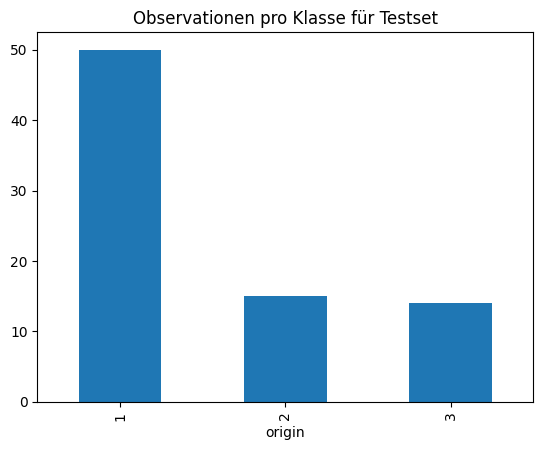

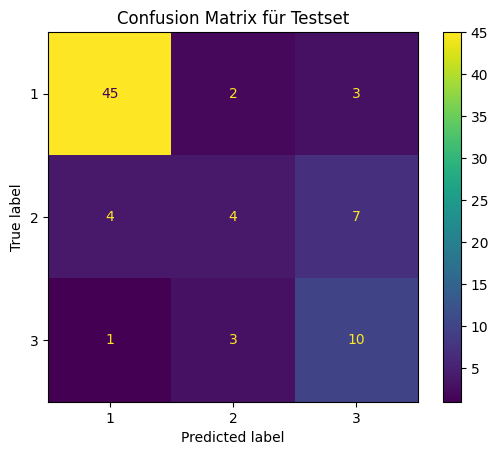



Random State: 1
Trainingsfehler: 0.25559105431309903
Testfehler: 0.189873417721519


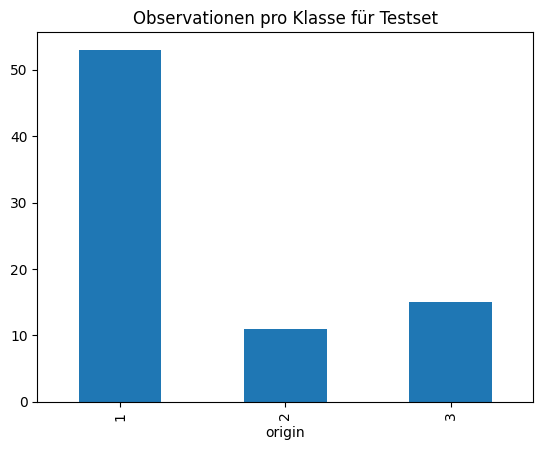

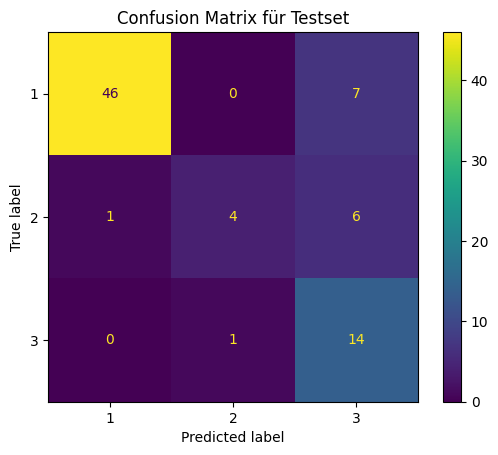



Random State: 2
Trainingsfehler: 0.24281150159744413
Testfehler: 0.3291139240506329


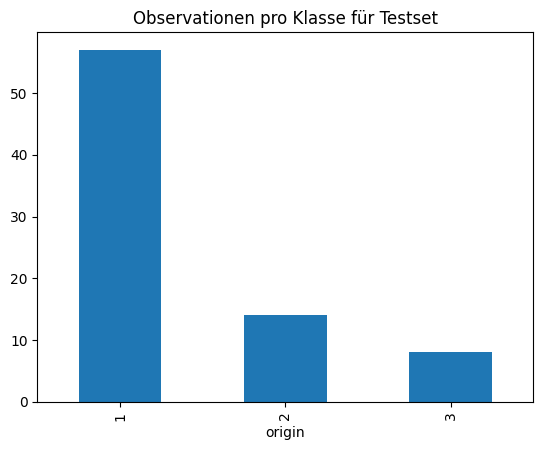

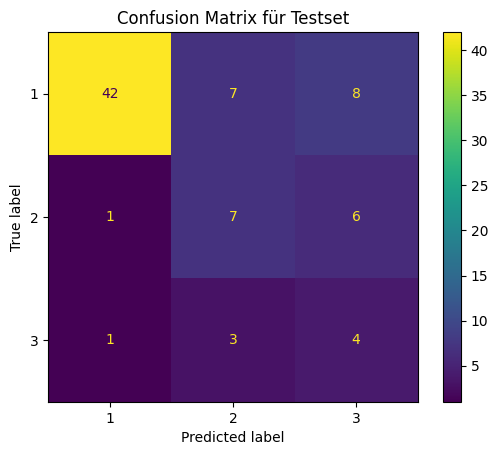



Random State: 3
Trainingsfehler: 0.25559105431309903
Testfehler: 0.2784810126582279


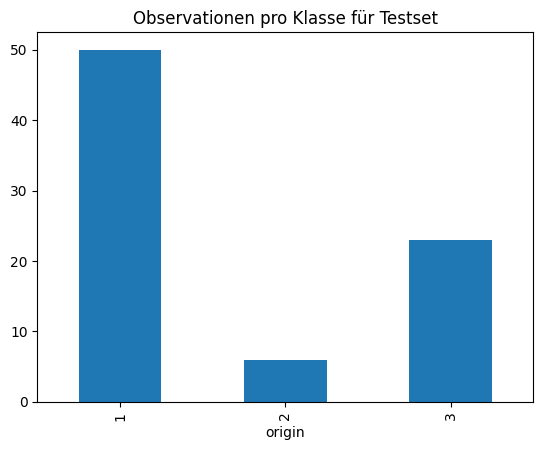

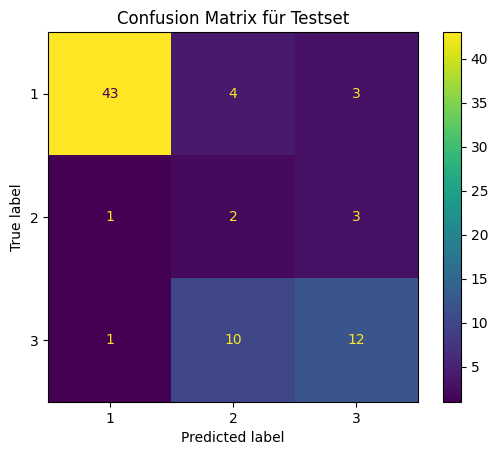



Random State: 4
Trainingsfehler: 0.2587859424920128
Testfehler: 0.2911392405063291


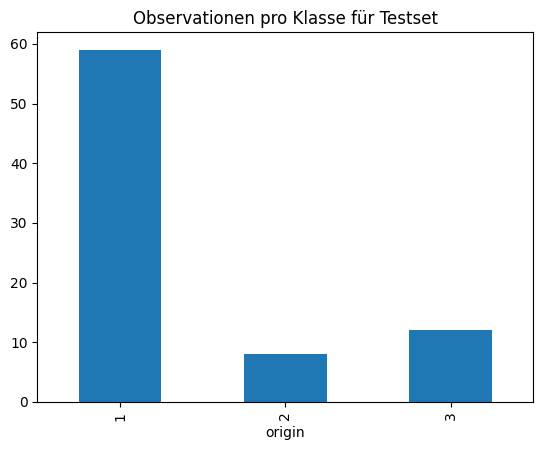

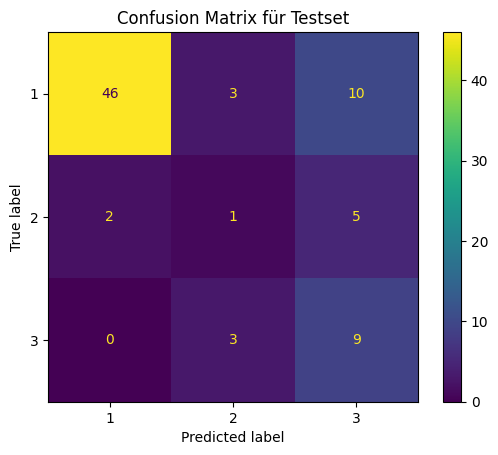



Random State: 5
Trainingsfehler: 0.23961661341853036
Testfehler: 0.35443037974683544


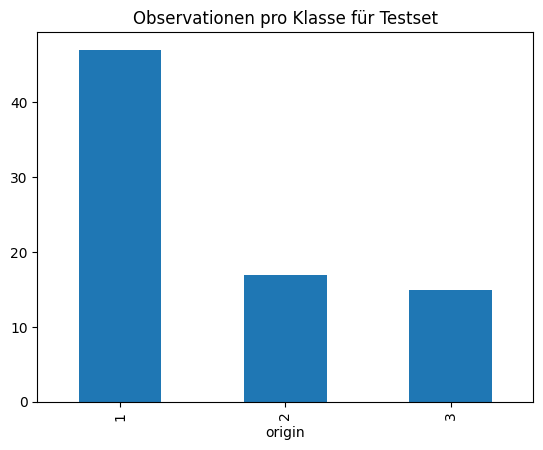

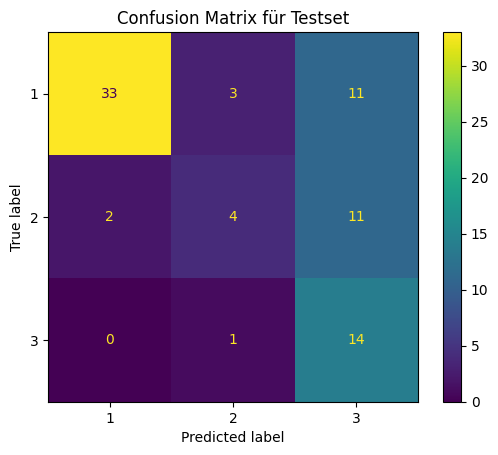



Random State: 6
Trainingsfehler: 0.24920127795527158
Testfehler: 0.240506329113924


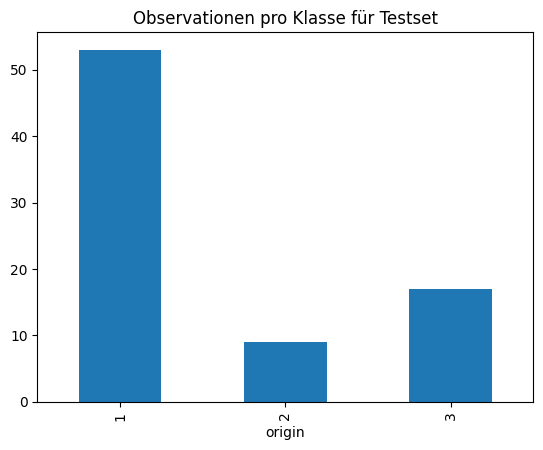

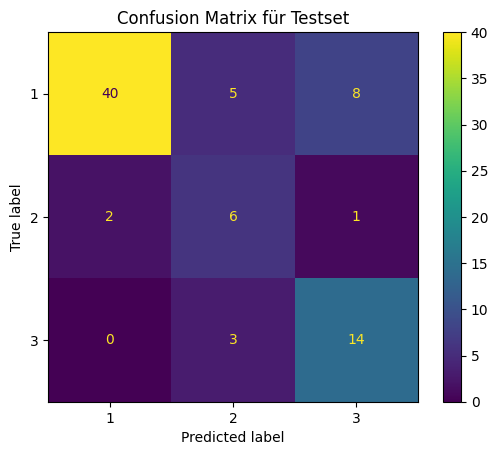



Random State: 7
Trainingsfehler: 0.23003194888178913
Testfehler: 0.379746835443038


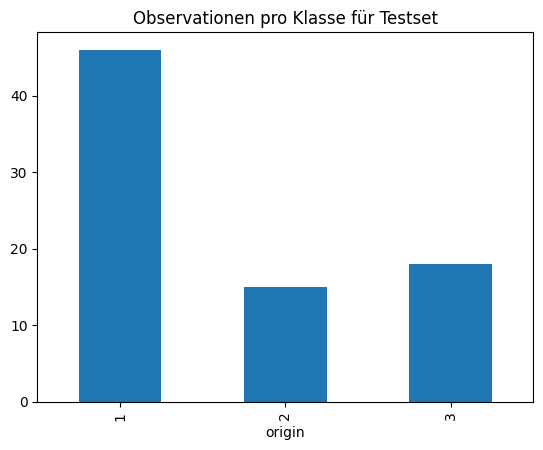

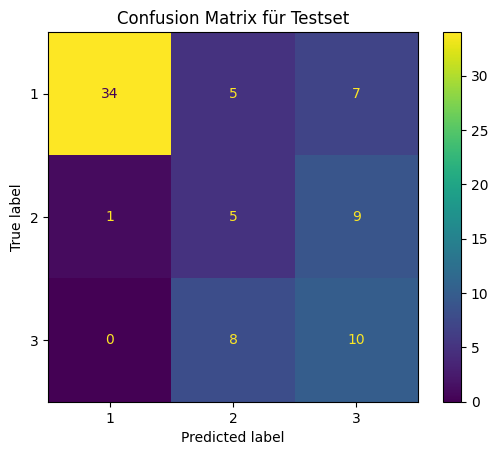



Random State: 8
Trainingsfehler: 0.23003194888178913
Testfehler: 0.2784810126582279


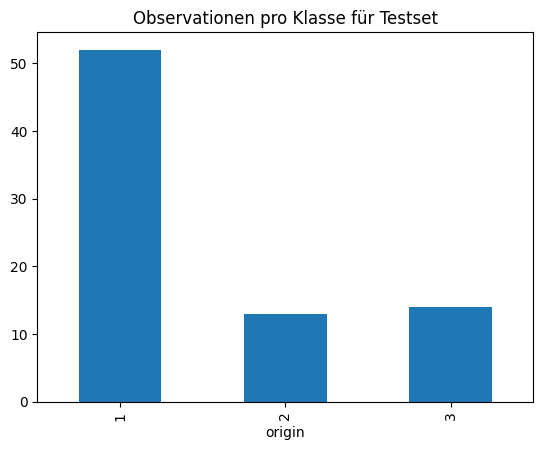

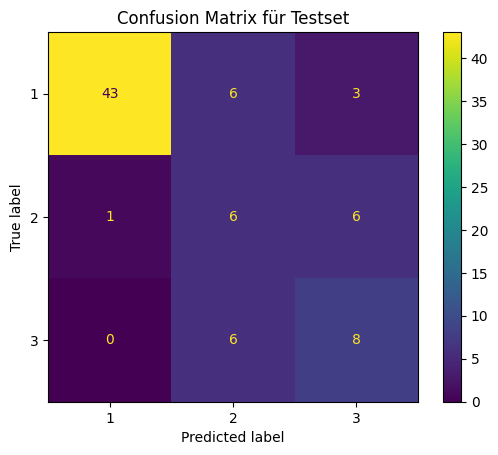



Random State: 9
Trainingsfehler: 0.2619808306709265
Testfehler: 0.26582278481012656


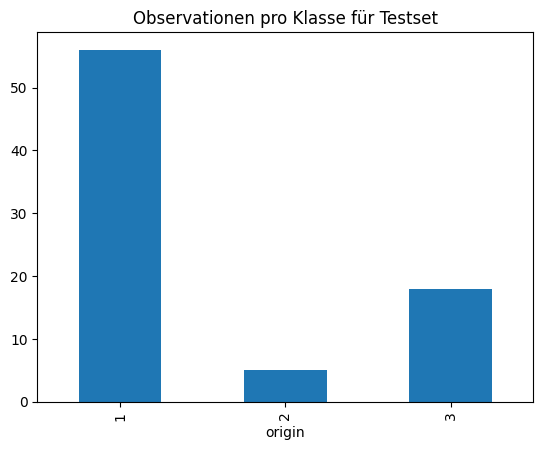

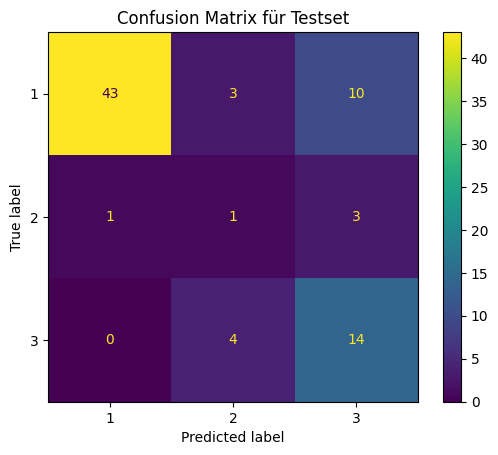

In [35]:
# Initialisiere Dataframe mit Vorhersagen
yPred = pd.DataFrame({'y': y, 'yPredTr0': 0})
# Wiederhole Berechnung auf 10 verschiedenen Random Seeds
for i in range(10):
    # Split in Train und Validierungsset
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=i)
    # Initalisiere LDA Klassifikator
    ldaAuto = LinearDiscriminantAnalysis()
    # Trainier LDA Klassifikator
    ldaAuto.fit(XTrain, yTrain)
    # Berechne Conusion Matrix
    confMat = confusion_matrix(yTest, ldaAuto.predict(XTest))
    # Gebe Random State aus
    print('Random State:', i)
    # Gebe Trainingsfehler aus
    print('Trainingsfehler:', 1-ldaAuto.score(XTrain, yTrain))
    # Gebe Testfehler aus
    print('Testfehler:', 1-ldaAuto.score(XTest, yTest))
    # Plotte absolute Häufigkeiten der Observationen im Testset
    yTest.value_counts().sort_index().plot.bar()
    plt.title('Observationen pro Klasse für Testset')
    plt.show()
    # Berechne Confusionmatrix
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat,
                                  display_labels=ldaAuto.classes_)
    # Plotte Confusionmatrix
    disp.plot()
    plt.title('Confusion Matrix für Testset')
    plt.show()
    # Neue Zeile in Ausagabe
    print('\n')
    # Fülle Dataframe mit Vorhersagen
    colTrain = 'yPredTr' + str(i)
    yPred.loc[XTrain.index, colTrain] = ldaAuto.predict(XTrain)
    colTest = 'yPredTe' + str(i)
    yPred.loc[XTest.index, colTest] = ldaAuto.predict(XTest)

In [36]:
# Prüfe welche Observationen im Training bzw. Test richtig zugeordnet wurden
yPredBool = yPred.drop('y', axis=1) == np.resize(y, (yPred.shape[0],1))
# Berechne wie oft die Observation in den 10 Versuchen richtig klassifiziert wurde
yPredTrue = yPredBool.sum(axis=1)

In [37]:
# Anteil der Observationen, welche nie richtig klassifiziert wurden, am aktuellen Testset - "schwierige Observationen"
len(yPredTrue[yPredTrue == 0].index.intersection(yTest.index)) / yTest.shape[0]

0.189873417721519

In [38]:
for i in range(10):
    # Split in Train und Validierungsset
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=i)
    # Initalisiere LDA Klassifikator
    ldaAuto = LinearDiscriminantAnalysis()
    # Trainier LDA Klassifikator
    ldaAuto.fit(XTrain, yTrain)
    # Berechne Conusion Matrix
    confMat = confusion_matrix(yTest, ldaAuto.predict(XTest))
    # Gebe Random State aus
    print('Random State:', i)
    # Gebe Trainingsfehler aus
    print('Trainingsfehler:', 1-ldaAuto.score(XTrain, yTrain))
    # Gebe Testfehler aus
    print('Testfehler:', 1-ldaAuto.score(XTest, yTest))
    # Gebe Anteil der schiwerig zu klassifierenden Observationen aus
    print('Anteil schwierige Observationen:', len(yPredTrue[yPredTrue == 0].index.intersection(yTest.index)) / yTest.shape[0])
    # Neue Zeile in Ausagabe
    print('\n')

Random State: 0
Trainingsfehler: 0.2460063897763578
Testfehler: 0.25316455696202533
Anteil schwierige Observationen: 0.1518987341772152


Random State: 1
Trainingsfehler: 0.25559105431309903
Testfehler: 0.189873417721519
Anteil schwierige Observationen: 0.12658227848101267


Random State: 2
Trainingsfehler: 0.24281150159744413
Testfehler: 0.3291139240506329
Anteil schwierige Observationen: 0.21518987341772153


Random State: 3
Trainingsfehler: 0.25559105431309903
Testfehler: 0.2784810126582279
Anteil schwierige Observationen: 0.16455696202531644


Random State: 4
Trainingsfehler: 0.2587859424920128
Testfehler: 0.2911392405063291
Anteil schwierige Observationen: 0.189873417721519


Random State: 5
Trainingsfehler: 0.23961661341853036
Testfehler: 0.35443037974683544
Anteil schwierige Observationen: 0.25316455696202533


Random State: 6
Trainingsfehler: 0.24920127795527158
Testfehler: 0.240506329113924
Anteil schwierige Observationen: 0.13924050632911392


Random State: 7
Trainingsfehler: